# Probabilistic Programming Project 1: LDA, CTM and DTM

## Content

#### Preliminaries

  1. Download the data
  
  2. Install and load required libraries

  3. Define utility functions

#### 1. Latent Dirichlet Allocation 

1. Print top 10 words in each topic

2. Plot representative distributions

#### 2. Can the topic model be used to define a topic-based similarity measure between documents?

1. Cosine similarity

2. Shao & Qin's improved document similarity index for latent Dirichlet allocation

#### 3. What about a new document? How can topics be assigned to it?

1. Assign topics via the word distributions per topic

2. Assign topics by using Bayes' rule on the word distributions per topic and topic distributions per document

#### 4. Correlated Topic Model

#### 5. Dynamic Topic Model

1. Dynamic topic model with prior re-computation

2. Dynamic topic model with resampling

#### Conclusions

#### Further work

## Download the data

Download document corpus from the scikit-learn website and load test data. Apart from 4 topics which are on the same subject (autos and motorcycles and baseball and hockey, respecively), the topics chosen for the corpus pretty well seprated. The correlated topics were chosen for the sake of the correlated and dynamic topic models.

In [1]:
from sklearn.datasets import fetch_20newsgroups

In [2]:
categories = ['alt.atheism', 
               'talk.religion.misc', 
               'comp.graphics', 
               'sci.space', 
               'rec.autos',
               'rec.motorcycles',
               'rec.sport.baseball',
               'rec.sport.hockey',
               'soc.religion.christian',
               'talk.politics.guns']

newsgroups = fetch_20newsgroups(subset = 'train', categories = categories)

test_documents = ["I had a peanuts butter sandwich for breakfast", 
                "I like to eat almonds, peanuts and walnuts", 
                "My neighbor got a little dog yesterday",
                "Cats and dogs are mortal enemies",
                "You mustn't feed peanuts to your dog"]

## Install and load required libraries

Bear in mind that I am using **python-2.7** and **pymc-2.3.7** in my anaconda environment.

In [4]:
!pip install pymc

You are using pip version 7.1.0, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import pymc as pm
import numpy as np
import scipy as sp
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/matei/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/matei/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
data, vocabulary = preprocessing(newsgroups.data)

topics = len(categories)
no_of_words = len(vocabulary)
no_of_docs = len(data)

## Define utility functions

The **preprocessing** function filters, stems and tokenizes the document corpus, reurning the processed data and the vocabulary.

The **extract_docs_from_corpus** function does some prior preprocessing, selecting a given numer of **samples per topic** and a **maximum number of samples** for each document in the corpus.

The **reshape_trace** functions reshapes the traces of deterministic variables to match those of non-deterministic $\theta$ or $\phi$. This will be employed later on, in the Correlated and Dynamic topic models. Those models, alongside our utility and plot functions, work with arrays of shape $[[a_1, b_1], [a_2, b_2]]$, whilst our deterministic variables have the shape $[[a_1, a_2], [b_1, b_2]]$.

**calculate_trace_mean**, **calculate_trace_mode** and **print_top_words_per_topic** have suggestive enough names.

In [34]:
def extract_docs_from_corpus(documents, 
                            samples_per_topic,
                            max_no_of_samples):
    from copy import deepcopy
    initial_documents_all = deepcopy(documents)

    documents_all = [d.lower().replace('\n', ' ') for d in documents]
    for character in list(string.punctuation + "0123456789"):
        documents_all = [d.replace(character, ' ').replace('', '') for d in documents_all]

    documents = []
    targets = []
    count_dict = {}

    for ind, (document, target) in enumerate(list(zip(documents_all, newsgroups.target))):
        if target in count_dict:
            if count_dict[target] < samples_per_topic:
                count_dict[target] += 1
            else:
                continue
        else:
            count_dict[target] = 1
        documents.append(document)
        targets.append(target)

        if len(documents) >= max_no_of_samples: # TODO 50
            break
                
    return documents

def preprocessing(documents, 
                  vocabulary = None, 
                  samples_per_topic = 5, 
                  max_no_of_samples = 35, 
                  is_test = False):
    
    if is_test == False:
        documents = extract_docs_from_corpus(documents, samples_per_topic, max_no_of_samples)
            
    processed_docs = []

    ps = PorterStemmer()

    stop = [ps.stem(sw).encode('ascii') for sw in stopwords.words('english')]  + list(string.punctuation)
    stops = []

    for s in stop:
        tokstop = word_tokenize(s)
        for tk in tokstop:
            stops.append(tk)

    for doc in documents:
        tokenized_doc = word_tokenize(doc)
        stop_doc = []
        for tokdoc in tokenized_doc:
            if tokdoc not in stops:
                stop_doc.append(tokdoc)
        processed_doc = []
        for sdoc in stop_doc:
            processed_doc.append(ps.stem(sdoc).encode('ascii'))
        processed_docs.append(processed_doc)

    wordsintxt = [item for sublist in processed_docs for item in sublist]
    
    if vocabulary is None:
        vocabulary = {}
        counter = 0

        for index, eachword in enumerate(wordsintxt):
            freq = vocabulary.get(eachword, None)
            if freq == None:
                vocabulary[eachword] = counter
                counter += 1

    data = []

    for doc in processed_docs:
         #TODO: treat new words case
        temp_data = [vocabulary[word] for word in doc if word in vocabulary]
        data.append(temp_data)

    return (data, vocabulary)

def calculate_trace_mean(trace):
    trace_fin = []
    for sample in trace:
        arr = []
        sample_t = sample.transpose()
        for element in sample_t:
            arr.append(sp.mean(element))
        trace_fin.append(np.array(arr))
    return trace_fin

def calculate_trace_mode(trace):
    trace_fin = []
    for sample in trace:
        arr = []
        sample_t = sample.transpose()
        for element in sample_t:
            arr.append(sp.stats.mode(element)[0][0])
        trace_fin.append(np.array(arr))
    return trace_fin

def reshape(trace, iterations):
    new_shape = []

    for iteration in range(iterations):
        temp = []
        for sample in trace:
            temp.append(sample[iteration])
        new_shape.append(np.array(temp))

    return new_shape

def print_top_words_per_topic(topics, phi, no_words = 10):
    vocabulary_inv = {v : k for k, v in vocabulary.items()}

    print("Most important " + str(no_words) + " words in each topic:")
    for topic in range(topics):
        top_indexes = np.argsort(phi[topic])[-no_words:]
        top_words = [vocabulary_inv[index] for index in top_indexes]
        print("Topic #" + str(topic + 1) + ": " + str(top_words))

# Latent Dirichlet Allocation

We compute the LDA algorithm as it described in the project assignment by using the **Dirichlet** and **CompletedDirichlet** functions in PyMC. The latter of the two "completes" the former by returning the full-sized sample, while the former returns $n - 1$ samples. The **Container** method in PyMC creates a variable object list that can be passed to the model as a standalone variable. The priors $\alpha$ and $\beta$ are considered fixed unit arrays.

The latent Dirichlet allocation algorithm is as follows:

1. Draw $\phi_d = Dirichlet(\beta)$

2. Draw $\theta_t = Dirichlet(\alpha)$

3. For each $d, t$:

  3.1. $z_{d, t} = Multinomial(\theta_d)$
  
  3.2. $w_{d, t} = Multinomial(\phi_{z_{t, d}})$
  
where $d$ and $t$ represents the documents and topics, respectively.

We have computed LDA with 100 000 samples and 90 000 burnouts.

In [6]:
def LDA(topics = topics,
        no_of_words = no_of_words,
        no_of_docs = no_of_docs,
        samples = 4000, 
        burnout = 1000):
    
    alpha = np.ones(topics)
    beta = np.ones(no_of_words)

    
    theta = pm.Container([pm.CompletedDirichlet("theta" + str(doc), \
                                                pm.Dirichlet("ptheta" + str(doc), 
                                                             theta = alpha)) 
                          for doc in range(no_of_docs)])

    phi = pm.Container([pm.CompletedDirichlet("phi" + str(topic), 
                                              pm.Dirichlet("pphi" + str(topic), 
                                                           theta = beta)) 
                        for topic in range(topics)])

    Wd = [len(doc) for doc in data]

    Z = pm.Container([pm.Categorical("Z" + str(doc), 
                                        p = theta[doc], 
                                        size = Wd[doc], 
                                        value = np.random.randint(topics, size = Wd[doc])) 
                      for doc in range(no_of_docs)])

    W = pm.Container([pm.Categorical("W" + str(doc) + str(word),
                                        p = pm.Lambda("phi_z" + str(doc) + str(word), 
                                                      lambda z = Z[doc][word], phi = phi: phi[z]),
                                        value = data[doc][word],
                                        observed = True)
                      for doc in range(no_of_docs) 
                      for word in range(Wd[doc])])
    
    model = pm.Model([theta, phi, Z, W])
    mcmc = pm.MCMC(model)
    mcmc.sample(samples, burnout)
    
    traces = {'phi_tr': [mcmc.trace('phi' + str(topic))[:][:, 0] for topic in range(topics)],
              'theta_tr': [mcmc.trace('theta' + str(doc))[:][:, 0] for doc in range(no_of_docs)],
              'Z_tr': [mcmc.trace('Z' + str(doc))[:] for doc in range(no_of_docs)]}
    
    return traces

In [13]:
lda_results = LDA(samples = 100000, burnout = 90000)

 [-----------------100%-----------------] 100000 of 100000 complete in 21499.9 sec

In [14]:
lda_phi_mean = calculate_trace_mean(lda_results['phi_tr'])
lda_theta_mean = calculate_trace_mean(lda_results['theta_tr'])
lda_Z_mode = calculate_trace_mode(lda_results['Z_tr'])

### Print top 10 words in each topic

In [15]:
print_top_words_per_topic(topics, lda_phi_mean)

Most important 10 words in each topic:
Topic #1: ['uppsala', 'univ', 'control', 'excess', 'infantil', 'honest', 'reffer', 'issu', 'aesthet', 'write']
Topic #2: ['pocket', 'question', 'vnew', 'delta', 'stomach', 'pal', 'childish', 'second', 'select', 'secular']
Topic #3: ['bless', 'feder', 'portray', 'centr', 'organ', 'newnham', 'ago', 'lead', 'voic', 'bp']
Topic #4: ['acadia', 'mundan', 'gaul', 'mormon', 'rickman', 'daddi', 'clari', 'june', 'wast', 'latter']
Topic #5: ['skate', 'behavior', 'soooo', 'lord', 'previous', 'acadiau', 'ozon', 'denmark', 'psi', 'crimin']
Topic #6: ['cheap', 'trophi', 'violenc', 'lose', 'chapter', 'utk', 'complic', 'lenient', 'oop', 'contributor']
Topic #7: ['thee', 'decid', 'com', 'rbd', 'emot', 'newshost', 'vfq', 'lot', 'jurisdict', 'loan']
Topic #8: ['palmer', 'loan', 'platform', 'node', 'submiss', 'uh', 'lucif', 'next', 'open', 'yanke']
Topic #9: ['jame', 'gballent', 'correspond', 'sick', 'member', 'skin', 'august', 'nowher', 'larri', 'sex']
Topic #10: ['b

### Plot distirbutions

Plotting functions to better understand the results through visualization. Peculiar enough, the **plot_topic_dist_per_doc** and **plot_word_dist** generate some blank space before the actual plots, bug which I haven't had the chance to solve.

In [72]:
def plot_topic_dist_per_doc(theta = lda_theta_mean):
    fig, ax = plt.subplots(len(theta), 1, figsize = (10, 160))
    
    for i, t in enumerate(theta):
        ax[i].bar(range(len(t)), t)
        ax[i].set_title("Topic distribution for document #" + str(i + 1))
        ax[i].set_xticks([j for j in range(len(t))])
        ax[i].set_xlabel('Topics')
        ax[i].set_ylabel('Proportions')
    
    plt.suptitle("Topic distributions per document")
    fig.subplots_adjust(hspace = 0.5, wspace = 0.5)
    plt.show()

def plot_no_of_words_per_topic(words = lda_Z_mode):
    fig, ax = plt.subplots(1, 1)
    topic_dist = dict()
    for k_i in words:
        for k in k_i:
            if k not in topic_dist:
                topic_dist[k] = 0
            topic_dist[k] += 1
    ax.bar(topic_dist.keys(), topic_dist.values())
    ax.set_xticks([i for i in range(len(topic_dist))])
    ax.set_xlabel("Topics")
    ax.set_ylabel("Counts")
    ax.set_title("Word count per topic")
    plt.show()

def plot_word_dist(phi = lda_phi_mean, vocabulary_inv = vocabulary_inv):
    fig, ax = plt.subplots(len(phi), 1, figsize = (20, 80))
    
    plt.xticks(rotation = 90)
    
    ticks = [i for i in range(100)]
    words = [vocabulary_inv[np.where(phi[0] == elem)[0][0]] for elem in phi[0][:100]]
    
    for i, t in enumerate(phi):
        ax[i].bar(range(len(t[:100])), t[:100], align = 'edge', width = 0.7)
        ax[i].set_title("Topic #" + str(i + 1))
        ax[i].set_xticks(ticks)
        ax[i].set_xticklabels(words, rotation = 80)
        ax[i].set_xlabel('Words')
        ax[i].set_ylabel('Proportions')
    
    plt.suptitle("First 100 words distributions per topic")
    fig.subplots_adjust(hspace = 0.5, wspace = 0.5)
    plt.show()

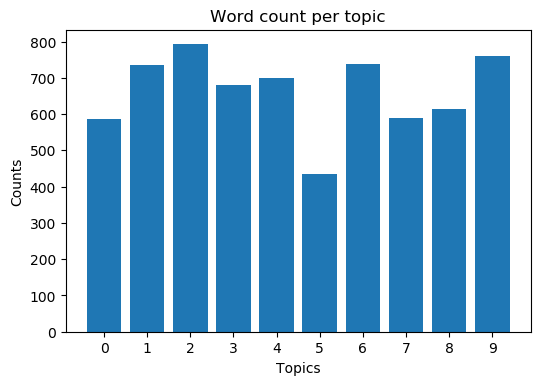

In [58]:
plot_no_of_words_per_topic()

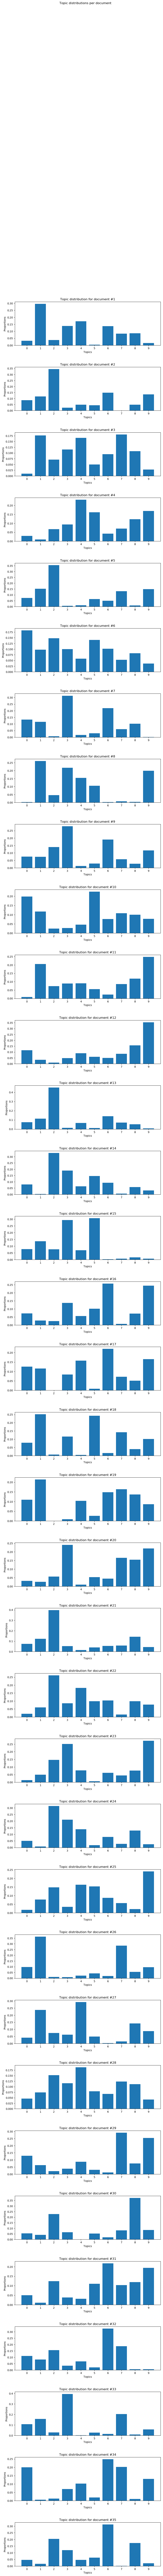

In [73]:
plot_topic_dist_per_doc()

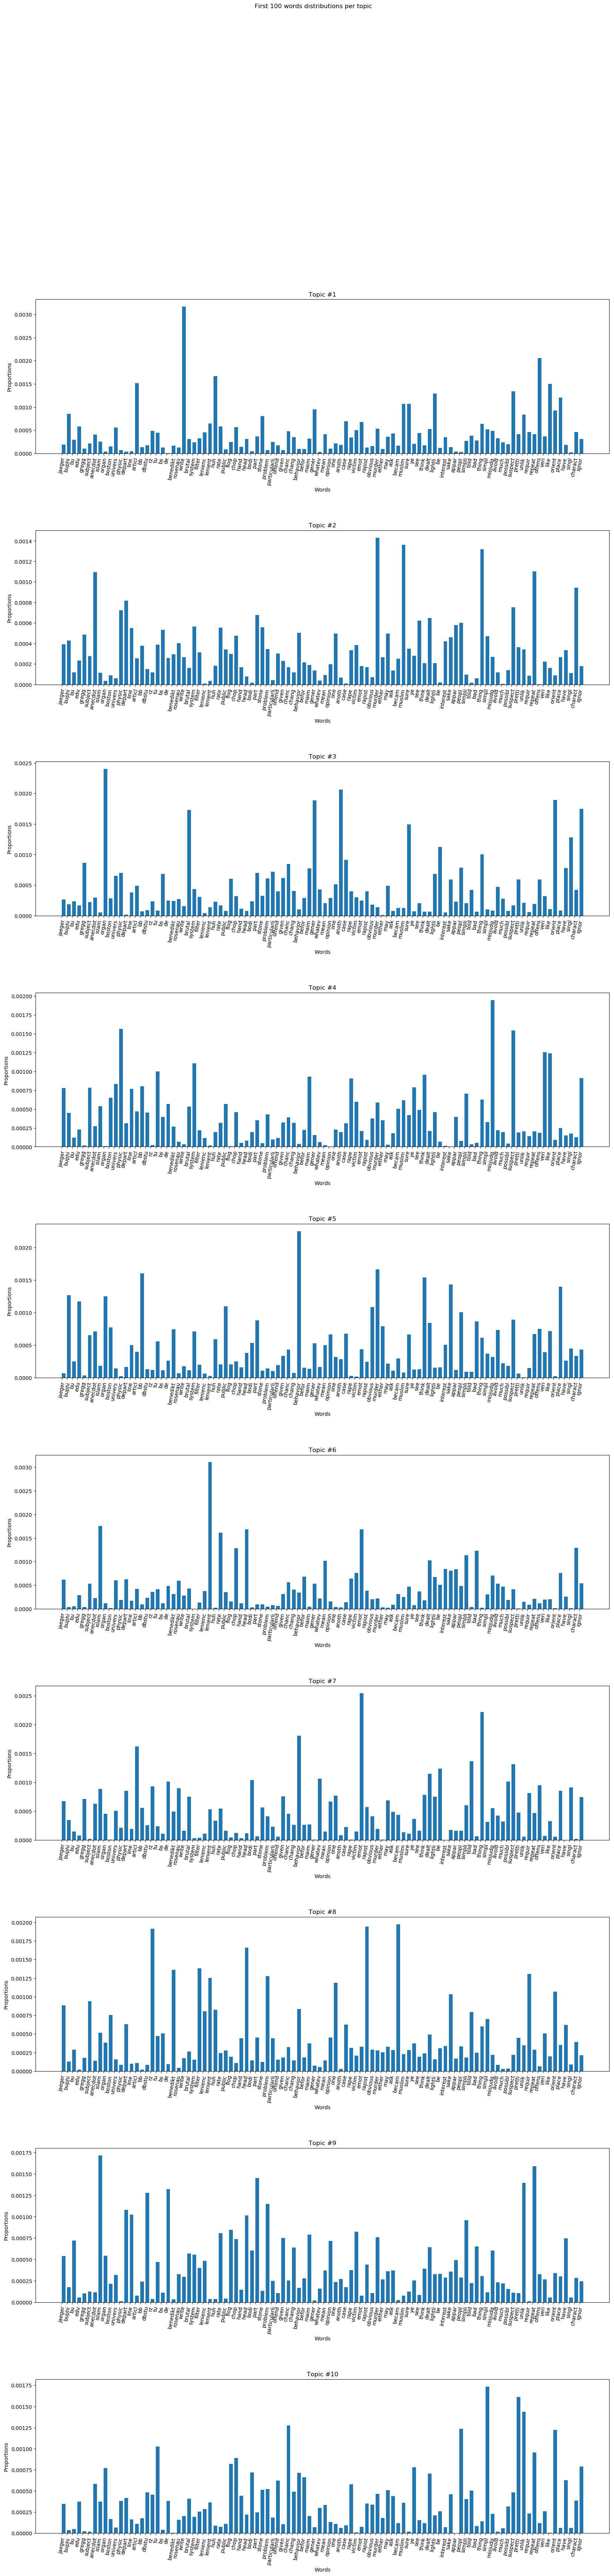

In [74]:
plot_word_dist()

## Can the topic model be used to define a topic-based similarity measure between documents?

I have computed the similarity between topics using two measure: cosine similarity and an improved similarity index.


#### Cosine Similarity

The former has been presented my <a href="https://practical-ml-fmi.github.io/ML/">$9^{th}$ Practical Machine Learning lecture</a>. This calculates the cosine of the angle between two vectors. The similarity between vectors is maximized the more "parallel" the vectors are.

#### Improved Similarity Index for Latent Dirichlet Allocation

I've found the latter while researching this topic and coming across the following paper: 

$Minglai \ Shao; Liangxi \ Qin, \ Text \ Similarity \ Computing \ Based \ on \ LDA \ Topic \ Model \ and \ Word \ Co-occurrence.$

The paper can be found here: https://www.atlantis-press.com/proceedings/sekeie-14/13639.

In their work, Shao & Qin approach text similarity by comuting the <a href='https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence'>Jensen-Shannon distance</a>, but they point out that "JS distance cannot distinguish
semantic associations among text topics". Thus, they provide a method of computing similarities based on the analysis of the semantic correlation between topics. This apporach is based on <a href="https://en.wikipedia.org/wiki/Co-occurrence">word co-occurence</a>.

Conserving the notations we've used so far, the formula they provide is:

$$Similarity \ (d_i, d_j) = \lambda \ JS(d_i, d_j) + (1 - \lambda) \frac{\sum_{n, m = 1}^{V} correlation(w_{i, n}, w_{j, m})}{V \ (V+1)}$$

where $d_{i,j}$ are documents, $JS$ is the Jensen-Shannon distance, $\lambda \in [0, 1]$ is the correlation coefficient between documents, V is the number of the feature words in the document, $w_{i, j}$ are words and:

$$correlation \ (w_{i, m}, w_{j, n}) = \frac{p_{m, n}}{\phi_{\theta_i, m} + \phi_{\theta_j, n} - p_{m, n}}$$

where $p_{m, n} = \phi_{i, m} \theta_i + \phi_{j, n} \theta_j$.

The correlation coefficient basically makes the $Similarity$ heuristic biased towards either $Jensen-Shannon$ or the latter part of the index. In their paper, the authors run this function with a fixed $\lambda \in [0.1, 0.9]$.

I have also tried useing the euclidean distance between the $\theta_i$ and $\theta_j$ in order to compute the correlation coefficient $\lambda$. The results are fairly similar with hardcoding $\lambda$ to 0.1, 0.2 or 0.3.

In [19]:
def correlation(phi, theta, i, j, vocinv_i, vocinv_j, vocabulary):
    sum_ = 0
    
    for m in range(len(vocinv_i)):
        for n in range(len(vocinv_j)):
            topic_i = np.where(lda_theta_mean[i] == lda_theta_mean[i].max())[0][0]
            topic_j = np.where(lda_theta_mean[j] == lda_theta_mean[j].max())[0][0]
            sum_ += phi[topic_i][m] * theta[i].max() + phi[topic_j][n] * theta[j].max() / \
                    (phi[topic_i][m] + phi[topic_j][n] - \
                     phi[topic_i][m] * theta[i].max() - phi[topic_j][n] * theta[j].max())
        
    return sum_

def similarity(theta, phi, document_i, document_j, vocabulary, corr_coef = 0.1):
    from scipy.spatial import distance
    
    data_i, vocab_i = preprocessing([newsgroups.data[document_i]])
    data_j, vocab_j = preprocessing([newsgroups.data[document_j]])
    
    vocinv_i = {v : k for k, v in vocab_i.items()}
    vocinv_j = {v : k for k, v in vocab_j.items()}
    
    return corr_coef * distance.jensenshannon(theta[document_i], theta[document_j]) + \
            (1 - corr_coef) * correlation(phi, 
                                          theta,
                                          document_i, 
                                          document_j, 
                                          vocinv_i, 
                                          vocinv_j, 
                                          vocabulary) / \
            (len(vocinv_i) * len(vocinv_j))

In the cell below we define a utility function to compute the improved similarity index from Shao & Qin's paper and cosine distance between documents. If no arguments are given, the function will compute the similarities between all documents.

In [31]:
def compute_similarities(no_of_docs_i = range(no_of_docs),
                        no_of_docs_j = range(no_of_docs)):

    from scipy.spatial import distance

    for i in range(no_of_docs_i):
        for j in range(no_of_docs_j):
            if i != j:
                print("Similarity between documents " + str(i + 1) + " and " + str(j + 1) + 
                      ": " + str(similarity(lda_theta_mean, 
                                            lda_phi_mean, 
                                            i, j,  
                                            vocabulary, 0.3)) +
#                                             distance.euclidean(lda_theta_mean[i], lda_theta_mean[j]))) +
                      " using improved similarity index.")
                print("Similarity between documents " + str(i + 1) + " and " + str(j + 1) + 
                      ": " + str(distance.cosine(lda_theta_mean[i], 
                                                 lda_theta_mean[j])) + 
                      " using cosine distance.")

In [15]:
lda_1 = LDA()

 [-----------------100%-----------------] 4001 of 4000 complete in 357.3 sec

In [17]:
lda_phi_mean = calculate_trace_mean(lda_1['phi_tr'])
lda_theta_mean = calculate_trace_mean(lda_1['theta_tr'])

In [32]:
compute_similarities(2, 2)

Similarity between documents 1 and 2: 0.2862499168330074 using improved similarity index.
Similarity between documents 1 and 2: 0.37923288934468613 using cosine distance.
Similarity between documents 2 and 1: 0.2290661426001145 using improved similarity index.
Similarity between documents 2 and 1: 0.37923288934468613 using cosine distance.


# What about a new document? How can topics be assigned to it?

I have implemented two topic assignment methods.

#### Topic assignment via word distributions $\phi$

First of these two is the formula given at the end of the follwing StackOverflow answer: https://stats.stackexchange.com/a/9479/61047. There, the author states that we can compute $p_{i,w}$, the probability of word $w$ in topic $i$, then take our new document,in which the $j^{th}$ word is $w_j$. The words are independent given the topic, so the probability is:

$$\prod_{j}^{} p_{i ,w}$$

However, I changed the original formula by applying Dirichlet smoothing to it.

To be noted that the nature of the data makes this function highly biased. In order for it to work properly the documents would have to be either very large, or extremely dense keyword-wise, two requirements our data fails to fulfill. The probabilities assigned by the model are very low for the sklearn corpus, making their product 0, due to numpy's limitations.

This is why I recommend applying this on the **test_documents** data in order to visualize more concrete results.

In [31]:
def new_doc_topic_assignment(new_data, phi_mean, smoothing_factor = .001):
    new_theta = []

    for i in range(topics):
        prod = 0
        for word_index in new_data[0]:
            prod += np.log(phi_mean[i][word_index] + smoothing_factor) #Dirichlet smoothing
        new_theta.append(np.exp(prod))
    
    return new_theta

#### Topic assignment by using Bayes' rule on $\phi$ and $\theta$

The second method, which is defined below, is computing the probability of a topic given a doument. For this I have employed Bayes' rule on $P(\phi_{i, n} \ | \ \theta_i^{mean})$, where $n$ is the $n^{th}$ word, $i$ denotes the $i^{th}$ topic and $\theta_i^{mean}$ represents the column-wise mean of the topic distribution for document $i$.

In [30]:
def bayes_rule_topic_assignment(new_data, phi_mean, theta_mean, smoothing_factor = .001):
    theta_col_mean = np.mean(theta_mean, axis  = 0)
    
    new_theta = []

    for i in range(topics):
        prod = 0
        for word_index in new_data[0]:
            prod += np.log(phi_mean[i][word_index] + theta_col_mean[i] + smoothing_factor) #Dirichlet smoothing
        new_theta.append(np.exp(prod))
    
    return new_theta

### Run topic assingment function on test corpus

In [9]:
data, vocabulary = preprocessing(test_documents, is_test = True)

topics = 2
no_of_words = len(vocabulary)
no_of_docs = len(data)

lda_test = LDA(topics = topics, no_of_words = no_of_words, no_of_docs = no_of_docs)

test_phi_mean = calculate_trace_mean(lda_test['phi_tr'])
test_theta_mean = calculate_trace_mean(lda_test['theta_tr'])

 [-----------------100%-----------------] 4000 of 4000 complete in 2.8 sec

/home/matei/anaconda3/envs/progprob/lib/python2.7/site-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


In [39]:
new_test_documents = ["My mouse likes to eat my peanuts but not my dog."]

new_data, new_vocabulary = preprocessing(new_test_documents, vocabulary)

new_theta = new_doc_topic_assignment(new_data, test_phi_mean)

for th_i in range(len(new_theta)):
    print('Probability of document to be drawn from topic ' + str(th_i + 1) + ' is ' + str(new_theta[th_i]) 
          + ' via product of word-topic probabilities.')

Probability of document to be drawn from topic 1 is 1.045772044798008e-06 via product of word-topic probabilities.
Probability of document to be drawn from topic 2 is 4.7960839280177125e-08 via product of word-topic probabilities.


In [38]:
new_theta = bayes_rule_topic_assignment(new_data, test_phi_mean, test_theta_mean)

for th_i in range(len(new_theta)):
    print('Probability of document to be drawn from topic ' + str(th_i + 1) + ' is ' + str(new_theta[th_i]) 
          + " via Bayes' rule.")

Probability of document to be drawn from topic 1 is 0.15827916461176045 via Bayes' rule.
Probability of document to be drawn from topic 2 is 0.041852073466168184 via Bayes' rule.


# Correlated Topic Model

Below we'll be reproducing Blei's algorithm from his paper: 

$Blei, \ David \ M; Lafferty, \ John \ D \ (2007). \ A \ Correlated \ Model \ of \ Science.$

The paper can be found at https://arxiv.org/pdf/0708.3601.pdf.

1. Draw $\eta = N(\mu, \Sigma)$

2. For each $n \in \{1 \ . \ . \ N_d\}$

  2.1. Draw $Z_{d, n} = Mult(softmax(\eta_d))$
  
  2.2. Draw $W_{d, n} = Mult(\beta_{z_{d, n}})$
  
Where $\mu$ and $\Sigma$ are a T-length vector and T x T matrix, respectively, and where T is the number of topics.

The logistic normal distributions that described $\eta$ (which is represented by $\theta$ in our code) is modeled by a multivariate normal distribution of mean $\alpha$ and Wishart variance distribution drawn from the number of topics. Here, $\alpha$ and the Wishart covariance matrix take the place of the $\mu$ and $\Sigma$ above.

The variable $\theta_s$ describes nothing more but the softmaxed $\theta$ values, so they may be properly used to furtherly model Z and W.

We have computed both the CTM and an LDA for result comparison with 40 000 samples and 30 000 burnouts.

For the sake of time and memory wise optimization, we prefer not to trace $\theta$ itself, as its values will not be employed after the modelling occurs.

In [12]:
def CTM(topics = topics,
        no_of_words = no_of_words,
        no_of_docs = no_of_docs,
        beta = np.ones(no_of_words), 
        samples = 4000, 
        burnout = 1000):
    
    alpha = np.ones(topics)
    beta = np.ones(no_of_words)
    
    cov = pm.Wishart("cov", topics, np.eye(topics), trace = False)

    theta = pm.Container([pm.MvNormalCov("theta" + str(doc), 
                                         alpha, 
                                         cov, 
                                         trace = False) 
                          for doc in range(no_of_docs)])

    @pm.deterministic
    def theta_s(theta = theta):
        return [sp.special.softmax(theta[doc]) for doc in range(no_of_docs)]

    phi = pm.Container([pm.CompletedDirichlet("phi" + str(topic), 
                                              pm.Dirichlet("pphi" + str(topic), theta = beta)) 
                        for topic in range(topics)])

    Wd = [len(doc) for doc in data]

    Z = pm.Container([pm.Categorical("Z" + str(doc), 
                                        p = theta_s[doc], 
                                        size = Wd[doc], 
                                        value = np.random.randint(topics, size = Wd[doc])) 
                                        for doc in range(no_of_docs)])

    W = pm.Container([pm.Categorical("W" + str(doc) + str(word),
                                        p = pm.Lambda("phi_z" + str(doc) + str(word), lambda z = Z[doc][word], phi = phi: phi[z]),
                                        value = data[doc][word],
                                        observed = True)
                                        for doc in range(no_of_docs) for word in range(Wd[doc])])

    model = pm.Model([cov, theta, theta_s, phi, Z, W])
    mcmc = pm.MCMC(model)
    mcmc.sample(samples, burnout)

    theta_s_tr = mcmc.trace('theta_s')[:]
    
    theta_s_tr = reshape(theta_s_tr, no_of_docs)
    
    traces = {'phi_tr': [mcmc.trace('phi' + str(topic))[:][:, 0] for topic in range(topics)],
              'theta_tr': theta_s_tr,
              'Z_tr': [mcmc.trace('Z' + str(doc))[:] for doc in range(no_of_docs)]}
    
    return traces

In [13]:
ctm_results = CTM(samples = 40000, burnout = 30000)

 [-----------------100%-----------------] 40000 of 40000 complete in 16492.5 sec

In [14]:
ctm_phi_mean = calculate_trace_mean(ctm_results['phi_tr'])
ctm_theta_mean = calculate_trace_mean(ctm_results['theta_tr'])
ctm_Z_mode = calculate_trace_mode(ctm_results['Z_tr'])

In [17]:
print_top_words_per_topic(topics, ctm_phi_mean)

Most important 10 words in each topic:
Topic #1: ['parent', 'watch', 'extra', 'spend', 'environ', 'anymor', 'div', 'rank', 'especi', 'leaf']
Topic #2: ['pars', 'necessari', 'wednesday', 'conduct', 'dept', 'mario', 'whose', 'clear', 'contributor', 'overlap']
Topic #3: ['denni', 'function', 'rocket', 'shown', 'dlite', 'founder', 'bitnet', 'symbol', 'titl', 'batf']
Topic #4: ['written', 'deadlin', 'also', 'differ', 'sanderson', 'biggest', 'inn', 'dissolv', 'ere', 'insur']
Topic #5: ['contin', 'ec', 'jupit', 'jgd', 'fax', 'victori', 'wallac', 'calcul', 'utk', 'msopher']
Topic #6: ['wayn', 'manuscript', 'corval', 'hi', 'nobli', 'past', 'surpris', 'judi', 'gmt', 'republican']
Topic #7: ['stafford', 'legal', 'obscur', 'famili', 'insight', 'bb', 'futur', 'brandei', 'steve', 'climb']
Topic #8: ['chair', 'rout', 'dsg', 'uucp', 'news', 'bogg', 'callison', 'complic', 'valu', 'cinch']
Topic #9: ['domain', 'utwent', 'honestli', 'lesson', 'reject', 'tikkannen', 'lightli', 'postmast', 'occasion', 'tru

In [7]:
ldacomp_results = LDA(samples = 40000, burnout = 30000)

lc_phi_mean = calculate_trace_mean(ldacomp_results['phi_tr'])

print_top_words_per_topic(topics, lc_phi_mean)

 [-----------------100%-----------------] 40001 of 40000 complete in 9318.1 secMost important 10 words in each topic:
Topic #1: ['patrick', 'thereof', 'bulk', 'dissolv', 'ramsey', 'uvic', 'unless', 'dividian', 'ballentin', 'donald']
Topic #2: ['duff', 'break', 'guru', 'pen', 'cagiva', 'tartabul', 'imho', 'brutal', 'rais', 'domain']
Topic #3: ['other', 'cit', 'netnew', 'forth', 'inde', 'intend', 'appropri', 'journeymen', 'evid', 'ass']
Topic #4: ['rime', 'minicad', 'andresen', 'inquiri', 'mormon', 'ego', 'packag', 'probabl', 'isol', 'qvfik']
Topic #5: ['jerk', 'evas', 'live', 'slp', 'habit', 'colt', 'duff', 'vote', 'dear', 'pocket']
Topic #6: ['mayb', 'green', 'daili', 'ahead', 'fax', 'drove', 'congreg', 'arrog', 'victim', 'south']
Topic #7: ['realli', 'car', 'european', 'enough', 'muslim', 'hesit', 'librari', 'possibl', 'prism', 'childcar']
Topic #8: ['thereof', 'earl', 'despit', 'usual', 'overrun', 'strictli', 'center', 'er', 'proceed', 'confirm']
Topic #9: ['present', 'variou', 'dxf'

/home/matei/anaconda3/envs/progprob/lib/python2.7/site-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


# Dynamic Topic Model

Unlike the last two models, Blei's paper lets some room for interpretability and thus I came up with two approaches for dynamic topic modelling: one that implies prior re-computation for every tick and another that involves resampling after every tick (we will use this term for denoting units of time).

Below we'll be reproducing Blei's algorithm as he descibes it in his paper co-authored with Lafferty: 

$Blei, \ David \ M; Lafferty, \ John \ D \ (2006). \ Dynamic \ topic \ models. \ Proceedings \ of \ the \ ICML.$

The paper can be found at https://mimno.infosci.cornell.edu/info6150/readings/dynamic_topic_models.pdf.

For every tick $t$:

1. $\beta_{t + 1} = \beta_{t} + N(\beta_{t}, \sigma)$

2. $\alpha_{t + 1} = \alpha_{t} + N(\alpha_{t}, \sigma)$

3. For each document:

  3.1. Draw $Z = Mult(softmax(\alpha_t))$

  3.2. Draw $W = Mult(softmax(\beta_{t, z}))$

Please note that, as Blei describes in his paper, "for a K-component model with V terms, let $\beta_{t,k}$ denote
the V-vector of natural parameters for topic k in slice t." Thus, his notation for $\beta$ coincides with our notation for $\theta$.

Same goes for $\alpha$ and $\phi$: "we use a logistic normal with mean $\alpha$ to express uncertainty over [document-specific topic] proportions".

For the sake of interpretability, we will conserve the notations we have used previously while building the LDA and CTM models.

The logistic normal distributions that have been added to both $\theta_{t+1}$ and $\phi_{t+1}$ for each tick have been modeled by a multivariate normal distribution of mean $\theta_{t}$ and a Wishart variance distribution drawn for the same $\theta_{t}$. The Wishart distribution generates the covariance matrix.

Another important note would be that, unfortunately, whenever I try to compute both of these models with a large number of samples (either 100000 or 40000) and an equivalently large burnout, my python process gets killed as it uses too much memory. I have also been unlucky with my Google Colab sessions, as they seem to fair worse than my personal machine even on small samples (4000 iterations with 1000 burnout). Thus, I am forced to compute the DTM only on a small sample.

## Dynamic Topic Model with prior re-computation

My first take on modelling Blei's DTM was to compute both $\phi$ and $\theta$ before the actual sampling takes place. Thus, the values of these two distibutions are enhanced with a those of a multivariate normal distribution for a number of given tick.

Steps 1 and 2 which you've seen above take place in the deterministic variables $\theta_t$ and $\phi_t$. The deterministic variables also compute some means and apply the softmax function on them. The mean is computed because for each sample in our initial prior $\theta$ (or $\phi$) we get $t$ values, one for each tick.

We have computed both the DTM and an LDA for result comparison with 1900 samples and 900 burnouts.

For the sake of time and memory wise optimization, we prefer not to trace $\theta$, $\phi$, the multivariate normal and Wishart distributions, as their values will not be employed after the modelling occurs.

In [15]:
def DTM(topics = topics,
        no_of_words = no_of_words,
        no_of_docs = no_of_docs, 
        samples = 4000, 
        burnout = 1000,
        no_of_ticks = 3):
    
    alpha = np.ones(topics)
    beta = np.ones(no_of_words)

    theta = pm.Container([pm.CompletedDirichlet("theta" + str(doc), 
                                                pm.Dirichlet("ptheta" + str(doc), 
                                                             theta = alpha), 
                                                trace = False) 
                          for doc in range(no_of_docs)])

    phi = pm.Container([pm.CompletedDirichlet("phi" + str(i), 
                                              pm.Dirichlet("pphi" + str(i), 
                                                           theta = beta), 
                                              trace = False) 
                        for i in range(topics)])

    Wd = [len(doc) for doc in data]

    @pm.deterministic
    def theta_t(theta = theta, no_of_ticks = no_of_ticks):
        theta_length = len(theta)
        theta = [theta[th_i] + \
                    pm.MvNormalCov('MVN' + str(time) + str(th_i), 
                            theta[th_i][0], 
                            pm.Wishart('cov' + str(time) + str(th_i), 
                                        len(theta[th_i][0]), 
                                        np.eye(len(theta[th_i][0])), 
                                        trace = False), 
                            trace = False).value
            for th_i in range(theta_length)
            for time in range(no_of_ticks)]

        n = len(theta[0][0])

        theta_sums = []
        for max_i in range(no_of_ticks - 1, no_of_ticks * theta_length, no_of_ticks):
            temp_sum = np.zeros(n)
            for i in range(max_i - no_of_ticks + 1, max_i + 1):
                for j in range(n):
                    temp_sum[j] += theta[i][0][j]
            theta_sum = list(temp_sum / no_of_docs)
            theta_sums.append(sp.special.softmax(np.array([theta_sum])))

        return theta_sums

    @pm.deterministic
    def phi_t(phi = phi, no_of_ticks = no_of_ticks):
        phi_length = len(phi)
        phi = [phi[ph_i] + \
                    pm.MvNormalCov('MVN' + str(time) + str(ph_i), 
                            phi[ph_i][0], 
                            pm.Wishart('cov' + str(time) + str(ph_i), 
                                        len(phi[ph_i][0]), 
                                        np.eye(len(phi[ph_i][0])), 
                                        trace = False), 
                            trace = False).value
            for ph_i in range(phi_length)
            for time in range(no_of_ticks)]

        n = len(phi[0][0])

        phi_sums = []

        for max_i in range(no_of_ticks - 1, no_of_ticks * phi_length, no_of_ticks):
            temp_sum = np.zeros(n)
            for i in range(max_i - no_of_ticks + 1, max_i + 1):
                for j in range(n):
                    temp_sum[j] += phi[i][0][j]
            temp_sum = list(temp_sum / no_of_docs)
            phi_sums.append(np.array([sp.special.softmax(sp.special.softmax(temp_sum))]))
            
        return phi_sums

    Z = pm.Container([pm.Categorical("Z" + str(doc), 
                                        p = theta_t[doc], 
                                        size = Wd[doc], 
                                        value = np.random.randint(topics, size = Wd[doc])) 
                                        for doc in range(no_of_docs)])

    W = pm.Container([pm.Categorical("W" + str(doc) + str(word),
                                        p = pm.Lambda("phi_z" + str(doc) + str(word), lambda z = Z[doc][word], phi = phi: phi_t[z].value),
                                        value = data[doc][word],
                                        observed = True)
                                        for doc in range(no_of_docs) for word in range(Wd[doc])])

    model = pm.Model([theta, phi, theta_t, phi_t, Z, W])
    mcmc = pm.MCMC(model)
    mcmc.sample(samples, burnout)

    theta_t_tr = mcmc.trace('theta_t')[:]
    phi_t_tr = mcmc.trace('phi_t')[:]
    
    traces = {'phi_tr': reshape(phi_t_tr, topics),
              'theta_tr': reshape(theta_t_tr, no_of_docs),
              'Z_tr': [mcmc.trace('Z' + str(doc))[:] for doc in range(no_of_docs)]}
    
    return traces

In [8]:
dtm_results = DTM(samples = 1900, burnout = 900)

 [-----------------100%-----------------] 1900 of 1900 complete in 139.8 sec

/home/matei/anaconda3/envs/progprob/lib/python2.7/site-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


In [9]:
dtm_phi_mean = calculate_trace_mean(dtm_results['phi_tr'])
dtm_theta_mean = calculate_trace_mean(dtm_results['theta_tr'])
dtm_Z_mode = calculate_trace_mode(dtm_results['Z_tr'])

In [10]:
print_top_words_per_topic(topics, dtm_phi_mean)

Most important 10 words in each topic:
Topic #1: ['jupit', 'possibl', 'natur', 'top', 'cloth', 'admit', 'month', 'gallichio', 'insur', 'book']
Topic #2: ['virtu', 'bathead', 'sinner', 'nigel', 'june', 'tactic', 'altern', 'pixel', 'nobodi', 'fact']
Topic #3: ['keep', 'andrew', 'due', 'way', 'provid', 'stone', 'freenet', 'uucp', 'agre', 'given']
Topic #4: ['cont', 'greg', 'earn', 'moral', 'shd', 'info', 'citizen', 'do', 'b', 'pay']
Topic #5: ['sociolog', 'jimmi', 'grow', 'lead', 'deserv', 'employ', 'astronom', 'tu', 'steveg', 'sail']
Topic #6: ['shutout', 'midway', 'purdu', 'thi', 'msopher', 'elp', 'jurisdict', 'current', 'huntsvil', 'polic']
Topic #7: ['clinton', 'oper', 'convieni', 'concept', 'davidian', 'request', 'implic', 'partnership', 'answer', 'soooo']
Topic #8: ['zwart', 'invit', 'distribut', 'jose', 'ran', 'monash', 'feder', 'thereof', 'feel', 'biggest']
Topic #9: ['came', 'stage', 'non', 'matter', 'hole', 'secur', 'textbook', 'box', 'perfect', 'greater']
Topic #10: ['evid', 'r

In [9]:
ldacomp_results = LDA(samples = 1900, burnout = 900)

lc_phi_mean = calculate_trace_mean(ldacomp_results['phi_tr'])

print_top_words_per_topic(topics, lc_phi_mean)

 [-----------------100%-----------------] 1900 of 1900 complete in 66.1 secMost important 10 words in each topic:
Topic #1: ['oppon', 'erod', 'comput', 'avail', 'accord', 'shd', 'drop', 'valiant', 'ball', 'axemen']
Topic #2: ['rug', 'stamber', 'tight', 'appl', 'proclaim', 'critic', 'spiritu', 'day', 'miss', 'conform']
Topic #3: ['alabama', 'tri', 'sex', 'subject', 'frame', 'cheesi', 'civil', 'phycholog', 'borst', 'care']
Topic #4: ['contributor', 'jose', 'belief', 'realiti', 'stomach', 'viewpoint', 'centuri', 'amber', 'inn', 'chanc']
Topic #5: ['isscck', 'suh', 'assault', 'gray', 'sail', 'gang', 'ancient', 'paula', 'correl', 'inter']
Topic #6: ['whole', 'oh', 'dead', 'imit', 'stage', 'mount', 'jump', 'cube', 'paula', 'provost']
Topic #7: ['strictli', 'hammer', 'profit', 'two', 'lift', 'binah', 'idea', 'vixi', 'grope', 'spec']
Topic #8: ['better', 'signific', 'excel', 'nation', 'sg', 'limit', 'expos', 'salvat', 'ndallen', 'presid']
Topic #9: ['stomach', 'built', 'write', 'whole', 'drove

/home/matei/anaconda3/envs/progprob/lib/python2.7/site-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


## Dynamic Topic Model with resampling

My second view on Blei's paper is that resampling  has to be done for each tick. Thus, I rewrote the deterministic variables $\theta_t$ and $\phi_t$ such that they only compute logistic normal addition for all prior samples given. 

This time, resampling gets done after Z and W are instantiated too, thus the mean computation gets done at the end of the loop over ticks. Softmax is still applied on the result of the deterministic $\theta_t$ and $\phi_t$.

We have computed both the DTMR and an LDA for result comparison with 4000 samples and 1000 burnouts.

In [7]:
def DTMR(topics = topics,
        no_of_words = no_of_words,
        no_of_docs = no_of_docs, 
        samples = 4000, 
        burnout = 1000,
        no_of_ticks = 3):
    
    alpha = np.ones(topics)
    beta = np.ones(no_of_words)

    theta = pm.Container([pm.CompletedDirichlet("theta" + str(doc), 
                                                pm.Dirichlet("ptheta" + str(doc), 
                                                             theta = alpha)) 
                          for doc in range(no_of_docs)])

    phi = pm.Container([pm.CompletedDirichlet("phi" + str(topic), 
                                              pm.Dirichlet("pphi" + str(topic), 
                                                           theta = beta)) 
                        for topic in range(topics)])

    Wd = [len(doc) for doc in data]

    Z = pm.Container([pm.Categorical("Z" + str(doc), 
                                        p = theta[doc], 
                                        size = Wd[doc], 
                                        value = np.random.randint(topics, size = Wd[doc])) 
                                        for doc in range(no_of_docs)])

    W = pm.Container([pm.Categorical("W" + str(doc) + str(word),
                                        p = pm.Lambda("phi_z" + str(doc) + str(word), lambda z = Z[doc][word], phi = phi: phi[z]),
                                        value = data[doc][word],
                                        observed = True)
                                        for doc in range(no_of_docs) for word in range(Wd[doc])])

    model = pm.Model([theta, phi, Z, W])
    mcmc = pm.MCMC(model)
    mcmc.sample(samples, burnout)

    phi_tr = [mcmc.trace('phi' + str(topic))[:][:, 0] for topic in range(topics)]
    theta_tr = [mcmc.trace('theta' + str(doc))[:][:, 0] for doc in range(no_of_docs)]

    phi_mean = calculate_trace_mean(phi_tr)
    theta_mean = calculate_trace_mean(theta_tr)

    for time in range(no_of_ticks - 1):

        @pm.deterministic
        def theta_t(theta = theta_mean):
            return [sp.special.softmax(theta[th_i] + \
                        pm.MvNormalCov('MVN' + str(time) + str(th_i), 
                                theta[th_i], 
                                pm.Wishart('cov' + str(time) + str(th_i), 
                                            len(theta[th_i]), 
                                            np.eye(len(theta[th_i])), 
                                            trace = False), 
                                trace = False).value)
                for th_i in range(len(theta))]

        @pm.deterministic
        def phi_t(phi = phi_mean):
            return [sp.special.softmax(sp.special.softmax(phi[ph_i] + \
                        pm.MvNormalCov('MVN' + str(time) + str(ph_i), 
                                phi[ph_i], 
                                pm.Wishart('cov' + str(time) + str(ph_i), 
                                            len(phi[ph_i]), 
                                            np.eye(len(phi[ph_i])), 
                                            trace = False), 
                                trace = False).value))
                for ph_i in range(len(phi))]

        Z = pm.Container([pm.Categorical("Z" + str(doc), 
                                            p = theta_t[doc], 
                                            size = Wd[doc], 
                                            value = np.random.randint(topics, size = Wd[doc])) 
                                            for doc in range(no_of_docs)])

        W = pm.Container([pm.Categorical("W" + str(doc) + str(word),
                                            p = pm.Lambda("phi_z" + str(doc) + str(word), 
                                                          lambda z = Z[doc][word], phi = phi: phi_t[z].value),
                                            value = data[doc][word],
                                            observed = True)
                                            for doc in range(no_of_docs) for word in range(Wd[doc])])

        model = pm.Model([theta, phi, theta_t, phi_t, Z, W])
        mcmc = pm.MCMC(model)
        mcmc.sample(samples / 10, burnout / 10)

        theta_t_tr = mcmc.trace('theta_t')[:]
        phi_t_tr = mcmc.trace('phi_t')[:]

        phi_t_tr = reshape(phi_t_tr, topics)
        theta_t_tr = reshape(theta_t_tr, no_of_docs)

        phi_mean = calculate_trace_mean(phi_t_tr)
        theta_mean = calculate_trace_mean(theta_t_tr)

    traces = {'phi_tr': phi_t_tr,
              'theta_tr': theta_t_tr,
              'Z_tr': [mcmc.trace('Z' + str(doc))[:] for doc in range(no_of_docs)]}
    
    return traces

In [8]:
dtmr_results = DTMR()

 [-----------------100%-----------------] 400 of 400 complete in 9.3 sec

/home/matei/anaconda3/envs/progprob/lib/python2.7/site-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


In [9]:
dtmr_phi_mean = calculate_trace_mean(dtmr_results['phi_tr'])

In [10]:
print_top_words_per_topic(topics, dtmr_phi_mean)

Most important 10 words in each topic:
Topic #1: ['came', 'gradual', 'howev', 'mob', 'still', 'purpos', 'modern', 'content', 'respond', 'minicad']
Topic #2: ['specul', 'love', 'geigel', 'nonetheless', 'div', 'encount', 'firmli', 'issu', 'babysitt', 'closer']
Topic #3: ['moral', 'implic', 'suppressedin', 'instanc', 'satan', 'renssela', 'steven', 'four', 'brink', 'subcontract']
Topic #4: ['government', 'add', 'duff', 'obvious', 'live', 'ceremoni', 'overlap', 'univers', 'conform', 'new']
Topic #5: ['conduct', 'pure', 'event', 'greater', 'moral', 'expect', 'propos', 'divison', 'russ', 'grew']
Topic #6: ['came', 'howev', 'matthew', 'dissolv', 'arrest', 'specif', 'q', 'node', 'import', 'local']
Topic #7: ['imho', 'iran', 'exactli', 'engag', 'evas', 'usual', 'draw', 'unit', 'passport', 'strobe']
Topic #8: ['almost', 'bluntli', 'divorc', 'histori', 'three', 'artic', 'rz', 'target', 'consid', 'oswald']
Topic #9: ['fuck', 'bulletin', 'ben', 'illinoi', 'minor', 'brigham', 'noos', 'baumgartn', 'ri

In [11]:
ldacomp_results = LDA()

lc_phi_mean = calculate_trace_mean(ldacomp_results['phi_tr'])

print_top_words_per_topic(topics, lc_phi_mean)

 [-----------------100%-----------------] 4000 of 4000 complete in 307.7 secMost important 10 words in each topic:
Topic #1: ['symbol', 'newnham', 'leaf', 'uokmax', 'traffic', 'submiss', 'rudyc', 'clemson', 'debat', 'muscular']
Topic #2: ['sweep', 'marietta', 'sinner', 'obes', 'aesthet', 'ec', 'muscular', 'next', 'faehl', 'pars']
Topic #3: ['your', 'lkim', 'ucdavi', 'th', 'pound', 'word', 'controversi', 'ec', 'vfq', 'rbd']
Topic #4: ['be', 'watch', 'vm', 'inde', 'foreground', 'assault', 'also', 'gonzalez', 'pdt', 'polic']
Topic #5: ['told', 'uunet', 'lift', 'refut', 'job', 'healthi', 'flatteri', 'hesit', 'danger', 'bank']
Topic #6: ['control', 'freeli', 'victori', 'do', 'quot', 'bit', 'whether', 'summari', 'emot', 'stanley']
Topic #7: ['lindgren', 'interest', 'imho', 'expect', 'mundan', 'saint', 'insert', 'bobbi', 'plu', 'appl']
Topic #8: ['subsequ', 'explain', 'nab', 'intern', 'origin', 'enjoy', 'worker', 'worth', 'gaul', 'mean']
Topic #9: ['perform', 'publish', 'nl', 'privat', 'despi

## Conclusions

Both the correlated and the dynamic topic models tend to learn the topics better than their LDA counterpart, at least on small samples.

In CTM's case, both topics #1 and #3 seems to have been learned with a higher degree of accuracy than the LDA. Those are ['parent', 'watch', 'extra', 'spend', 'environ', 'anymor', 'div', 'rank', 'especi', 'leaf'] and ['denni', 'function', 'rocket', 'shown', 'dlite', 'founder', 'bitnet', 'symbol', 'titl', 'batf'], respectively. As we may observe, both topics have been pretty well clustered, if we take into consideration the reduced sample space.

The dynamic topic model with prior re-computation, even with a very samll sample space - 1900 samples and 900 burnouts -, generated topic #5, which among other words, is defined by 'sociolog', 'lead', 'deserv', 'employ', 'astronom', which do have some correlation in between them if we consider the "occupations" space.

The dynamic topic model with resampling, gathered the following correlated words in topic #10: 'expect', 'involv', 'conduct', 'pure', 'event', 'greater', 'moral', 'establish', 'secular', 'melb'.

It is natural to assume that both CTM and DTM generate a much more accurate cluter of words per topic. However, as a sanity check, it would be best to run both CTM and DTM with at least 100 000 samples. As I have previously specified, I haven't been able to do this due to hardware limitations.

## Further work

1. Fix plotting bugs.

2. Run CTM and DTM with on a larger sample space.